In [1]:
import numpy as np
import pandas as pd
import os
import gc
"""Paths for folders of images."""
path = "/kaggle/input/lymphoma"

In [2]:
"""Various Imports"""
import keras
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, concatenate, add, BatchNormalization

Using TensorFlow backend.


In [3]:
"""Hyper-Parameters"""
img_data = None
num_classes = 0
# image_dim = (1400,1400)
patch_dim = (100, 100) #this would be the input size to the model
patch_size = 32
no_of_imgs = 50
batch_size = 50 
epochs = 5

In [4]:
"""Loading data from the files mentioned above"""

labels = {}

def prepareData(): 
    global lables
    file_names, file_labels = [],[]
#     this would make our program more generic, as data would now be loaded irrespective of the number of classes
    for val,class_ in enumerate(os.scandir(path),0):
        labels[val] = class_.name 
        file_names.extend([os.path.join(class_.path,img_name) for img_name in os.listdir(class_.path)])
        file_labels.extend([val]*len(os.listdir(class_.path)))
        
    img_data = pd.DataFrame({"Output":file_labels}, index = file_names).sample(frac = 1) #shuffling
    img_data = img_data.astype('category')
    img_data = pd.get_dummies(img_data)
    
    del file_names, file_labels
    gc.collect()
    
    return img_data

imgData = prepareData()
num_classes = len(labels) #as each value in the label would be defining a seperate class
print(f'num of classes are: {num_classes}')
print(f'The classes and their encoded values are: {labels}')
imgData.head()


num of classes are: 3
The classes and their encoded values are: {0: 'FL', 1: 'MCL', 2: 'CLL'}


,Output_0,Output_1,Output_2
/kaggle/input/lymphoma/CLL/sj-05-3165_006.tif,0,0,1
/kaggle/input/lymphoma/FL/sj-05-5389-R1_014.tif,1,0,0
/kaggle/input/lymphoma/CLL/sj-03-5521_004.tif,0,0,1
/kaggle/input/lymphoma/CLL/sj-05-3874-R2_003.tif,0,0,1
/kaggle/input/lymphoma/CLL/sj-05-3165_002.tif,0,0,1


In [5]:
train_size = int(imgData.shape[0]*0.8)
train_img_data = imgData.iloc[:train_size, :]
test_img_data = imgData.iloc[train_size:,:]

print("Test size  :{0}".format(test_img_data.shape))
print("Train size :{0}".format(train_img_data.shape))
    
def genPatches(image):
    global patch_size
    """
        returns normalized patches of size (patch_dim,patch_dim,3)
    """
    img_patches = []
    img_dim = image.shape[0]
    
    for i in range(0, img_dim, patch_size):
        for j in range(0, img_dim, patch_size):
            img_patch = image[i : i + patch_size, j : j + patch_size, :]
            #this is the default interpolation applied by cv2.resize
            img_patch = cv2.resize(img_patch, patch_dim, interpolation = cv2.INTER_LINEAR) 
            img_patch = img_patch / 256 #NORMALIZING THE PATCH
            img_patches.append(img_patch)
            
            del img_patch
            gc.collect()
            
    return img_patches, len(img_patches)

Test size  :(75, 3)
Train size :(299, 3)


In [6]:
def loadImages(start = 0, end = -1, name='train'):
    
    data = train_img_data if name=='train' else test_img_data
    
    x = [] #the patches
    y = [] #the resp labels
    
    end = data.shape[0] if end>data.shape[0] else end

    for i in range(start, end):
        img = cv2.imread(data.index[i],cv2.IMREAD_COLOR)
        img_dim = patch_size * (max(img.shape[0],img.shape[1])//patch_size + 1) #this would get an img_dim which would be a multiple of patch size
        img = cv2.cvtColor(cv2.resize(img,(img_dim,img_dim)),cv2.COLOR_BGR2RGB)
    
        imgPatches, patches_per_img = genPatches(img)
        
        del img
        gc.collect()
        
        x.extend(imgPatches)
        y.extend([data.iloc[i,:]] * patches_per_img)
        
    return np.array(x),np.array(y)

19360


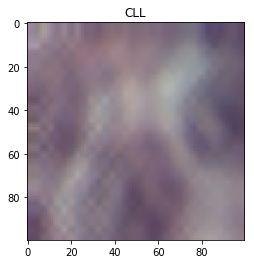

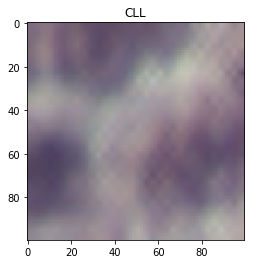

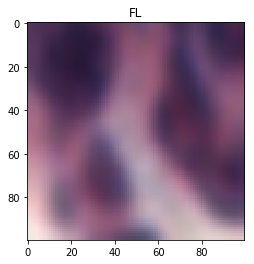

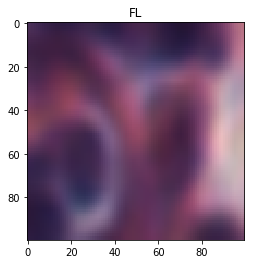

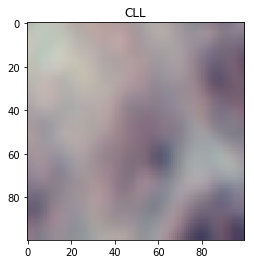

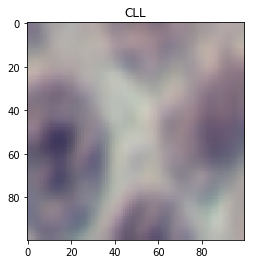

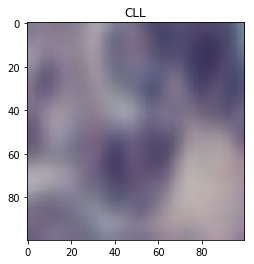

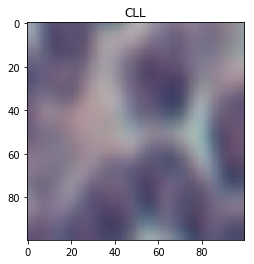

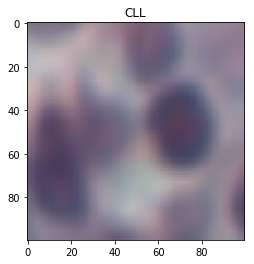

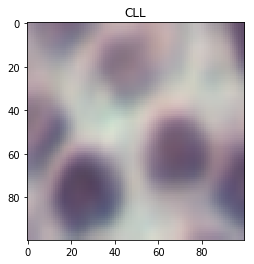

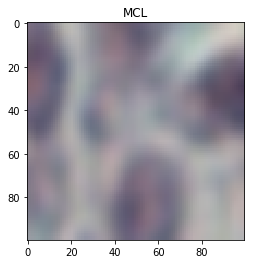

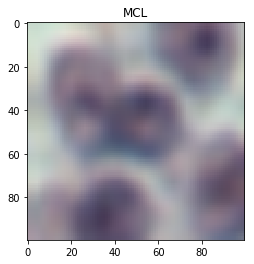

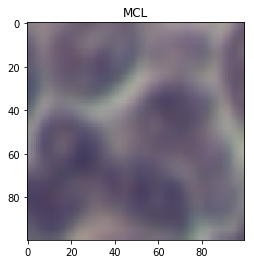

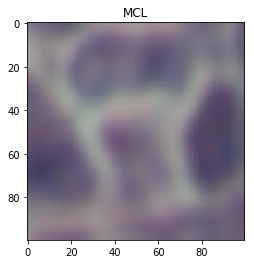

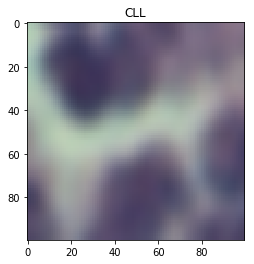

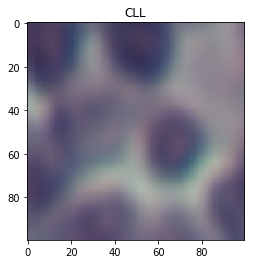

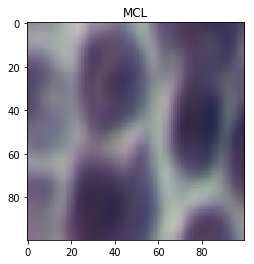

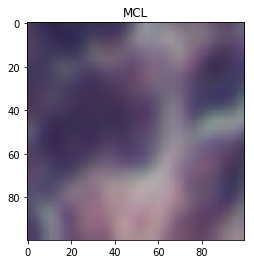

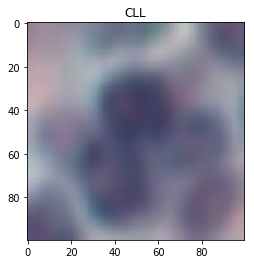

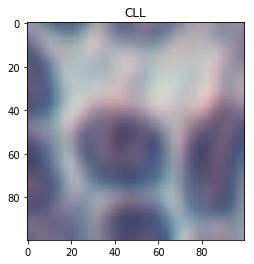

In [12]:
# x, y = loadImages(0,10, name = "train")
# print(f'{x.shape[0]}')
# for i,(patch,label) in enumerate(zip(x[::1000],y[::1000])):
# #     if i==5:
# #         break
#     plt.title(labels[np.argmax(label)])
#     plt.imshow(patch)
#     plt.show()

In [8]:
def DualAlexNet(num_classes = 3):
    
    inputLayer = Input((patch_dim[0], patch_dim[1], 3))
    path = BatchNormalization()(inputLayer)
    
    path1 = Conv2D(64, (5, 5), padding = 'same', data_format = 'channels_last', activation = 'relu')(path)
    path1 = MaxPooling2D((3, 3),strides = 2, padding = 'same')(path1)
    path1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(path1)
    path1 = MaxPooling2D((3, 3),strides = 3, padding = 'valid')(path1)
    path1 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(path1)
    path1 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(path1)
    path1 = Dropout(0.3, seed = 1)(path1)
    path1 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu')(path1)
    path1 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu')(path1)
    
    path2 = Conv2D(64, (5, 5), padding = 'same', data_format = 'channels_last', activation = 'relu')(path)
    path2 = MaxPooling2D((3, 3),strides = 2, padding = 'same')(path2)
    path2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(path2)
    path2 = MaxPooling2D((3, 3),strides = 3, padding = 'valid')(path2)
    path2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(path2)
    path2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(path2)
    path2 = Dropout(0.56, seed = 3)(path2)
    path2 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu')(path2)
    path2 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu')(path2)
    
    flatter = concatenate([path1, path2])
    flatter = Flatten()(flatter)
    
    denseLayer = Dense(1000, activation = 'relu')(flatter)
    denseLayer = Dense(250, activation = 'relu')(denseLayer)
    denseLayer = Dense(20, activation = 'relu')(denseLayer)
    outputLayer = Dense(num_classes, activation = 'softmax')(denseLayer)
    
    model = Model(inputLayer, outputLayer)
    model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    model.summary()
    return model

In [9]:
def fitModel(model, batch_size = 50, epochs = 5, no_of_imgs = 10):
    for i in range(0, train_img_data.shape[0], no_of_imgs):
        train_x,train_y = loadImages(start = i, end = i + no_of_imgs, name = 'train')
       
        model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, shuffle = True, verbose = 1)
        del train_x, train_y
        gc.collect()
    return model

In [10]:
model = DualAlexNet(num_classes)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100, 100, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 64) 4864        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 100, 100, 64) 4864        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
model = fitModel(model, batch_size, epochs, no_of_imgs)